# Tuning of hyperparameters
#### Script to train the model multiple times using different values for batch size and learning rate. The training is done using a small subset of the total training dataset and the results are validated against a different subset.

In [1]:
!git clone -l -s git://github.com/juanigp/CT-denoising.git cloned-repo
%cd cloned-repo
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

import os
from IPython.core.debugger import set_trace
from models.EDCNN import EDCNN
from utils import utils
import torch
import torch.nn as nn
import torch.utils.data.sampler as sampler
from torch.autograd import Variable
from matplotlib import pyplot as plt
import random
import numpy as np

Cloning into 'cloned-repo'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 217 (delta 107), reused 125 (delta 42), pack-reused 0
Receiving objects: 100% (217/217), 39.70 MiB | 24.71 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/cloned-repo
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
#csv file containing the directories of the lo res and ground truth patches
csv_file = r'/gdrive/My Drive/patches/1.csv' 
dataset = utils.CTVolumesDataset(csv_file)

#split of data in training, validation and testing data:
#the .csv is shuffled (using the same seed everytime for repeatability)
num_samples = len(dataset)
total_idx = list(range(num_samples))
random.seed(10)
random.shuffle(total_idx)

#pick 10% of samples to test
testing_samples_percentage = 0.1
split_index = int( num_samples * testing_samples_percentage )
#pick the first 10% of samples in the shuffled dataset for testing
testing_idx = total_idx[0 : split_index]
#pick the other 90% of samples in the shuffled dataset for training
training_idx = total_idx[split_index : num_samples]
#pick the first 10% of samples used for training. These are the samples that are going to be used for training in this script
training_subset_idx = training_idx[0:split_index]
#pick the second 10% of samples used for validation
validation_subset_idx = training_idx[split_index: 2 * split_index]

training_subset_sampler = sampler.SubsetRandomSampler(training_subset_idx)
validation_sampler = sampler.SubsetRandomSampler(validation_subset_idx)

FileNotFoundError: ignored

In [0]:
num_epochs = 100
bs = 32
lr_list = [0.01, 0.001, 0.0001, 0.00001]
criterion = nn.L1Loss()

training_losses = []
validation_losses = []

training_subset_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size = bs, sampler = training_subset_sampler)
validation_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size = bs, sampler = validation_sampler)

for lr in lr_list:
  training_loss_list = []
  validation_loss_list = []
  model = EDCNN()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)  
  if torch.cuda.is_available():
      model.cuda()
      criterion.cuda() 
  for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    model.train()
    for batch, (lo_res, hi_res) in enumerate(training_subset_dataloader):
      #add an extra dimension:
      lo_res = utils.var_or_cuda( lo_res.unsqueeze(1) )
      hi_res = utils.var_or_cuda(hi_res)
      if lo_res.size()[0] != bs:
          #print("batch_size != {} drop last incompatible batch".format( bs ))
          continue
      num_batch += 1
      #forward pass 
      outputs = model(lo_res)
      loss = criterion(outputs, hi_res.unsqueeze(1))
      epoch_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print('Training epoch [{}/{}]' .format(epoch+1) )     
    training_loss_list.append( epoch_loss/num_batches )
      
    model.eval()
    epoch_loss = 0
    num_batches = 0
    with torch.no_grad():
      for batch, (lo_res, hi_res) in enumerate(validation_dataloader):
        #add an extra dimension:
        lo_res = utils.var_or_cuda( lo_res.unsqueeze(1) )
        hi_res = utils.var_or_cuda(hi_res)
        if lo_res.size()[0] != bs:
            #print("batch_size != {} drop last incompatible batch".format( bs ))
            continue
        num_batch += 1
        #forward pass 
        outputs = model(lo_res)
        loss = criterion(outputs, hi_res.unsqueeze(1))
        epoch_loss += loss

      print('Validation epoch [{}/{}]'.format(epoch+1) )     
      validation_loss_list.append( epoch_loss/num_batches )
    
  training_losses.append( (training_loss_list, {"lr": lr, "batch_size" = bs} ) )
  validation_losses.append( (validation_loss_list, {"lr": lr, "batch_size" = bs} ) )
  
  

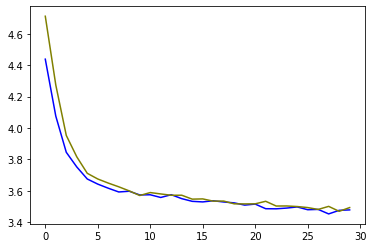

In [0]:
len(training_loss_list)
plt.plot(np.array(validation_loss_list)/(30*20), color = 'blue')
plt.plot(np.array(training_loss_list)/(30*20), color = 'olive')

In [0]:
'''
bs_list = [1, 2, 4, 8, 16, 32]
lr_list = [0.01, 0.001, 0.0001, 0.00001]
bs_np, lr_np = np.array(bs_list), np.array(lr_list)
bs_mat, lr_mat = np.meshgrid(bs_np, lr_np)
bs_np = np.resize(bs_mat, -1)
lr_np = np.resize(lr_mat, -1)

num_epochs = 30
criterion = nn.L1Loss()

training_losses = []
validation_losses = []

#for i in range(len(lr_np)):
for i in range(1):  
  training_loss_list = []
  validation_loss_list = []

  lr = int(lr_np[i])
  bs = int(bs_np[i])
  lr = 0.00005
  bs = 32

  #dataloader
  training_subset_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size = bs, sampler = training_subset_sampler)
  validation_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size = bs, sampler = validation_sampler)
  total_step = len(training_subset_dataloader)

  model = EDCNN()

  optimizer = torch.optim.Adam(model.parameters(), lr = lr)  
  if torch.cuda.is_available():
      model.cuda()
      criterion.cuda()
  for epoch in range(num_epochs):
    epoch_loss = 0
    
    model.train()

    for batch, (lo_res, hi_res) in enumerate(training_subset_dataloader):
      #add an extra dimension:
      lo_res = utils.var_or_cuda( lo_res.unsqueeze(1) )
      hi_res = utils.var_or_cuda(hi_res)
      if lo_res.size()[0] != bs:
          print("batch_size != {} drop last incompatible batch".format( bs ))
          continue

      #forward pass 
      outputs = model(lo_res)
      loss = criterion(outputs, hi_res.unsqueeze(1))
      epoch_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (batch+1) % 1 == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
              .format(epoch+1, num_epochs, batch+1, total_step, loss.item()))    
    training_loss_list.append(epoch_loss)
    
  
    model.eval()
    model.zero_grad()
    epoch_loss = 0

    with torch.no_grad():

      for batch, (lo_res, hi_res) in enumerate(validation_dataloader):

        #add an extra dimension:
        lo_res = utils.var_or_cuda( lo_res.unsqueeze(1) )
        hi_res = utils.var_or_cuda(hi_res)
        if lo_res.size()[0] != bs:
            print("batch_size != {} drop last incompatible batch".format( bs ))
            continue

        #forward pass 
        outputs = model(lo_res)
        loss = criterion(outputs, hi_res.unsqueeze(1))
        epoch_loss += loss

        if (batch+1) % 1 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, batch+1, total_step, loss.item()))
      validation_loss_list.append(epoch_loss)
    
  training_losses.append(training_loss_list)
  validation_losses.append(validation_loss_list)
  '''
  